# Simulation for Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind

# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    p = prob_lambda[current_k-1:]
    if prt: print('current no. cols (lambda):', current_k)
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1) 
                    
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            # if prt: print('normalized:', p)
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]

def sample_config(config, eta, N, no_colors, sites, uf=None, comp_constraints=None):
    
    if uf==None:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        comp_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for comp in uf.components():
            cl_n += 1
            min_constraint = no_colors
            comp_root = '-1,-1'
            for site_str in comp:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    comp_root = site_str
                cls[site[0],site[1]] = cl_n
            comp_constraints[comp_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    '''Randomly sample a color for each cluster'''
    for root in comp_constraints:
        max_col = comp_constraints[root]
        comp_color = np.random.choice((np.arange(1, max_col+1)))
        for site_str in uf.component(root):
            site = str2site(site_str)
            config[site[0],site[1]] = comp_color
            
    return config, uf, comp_constraints

    
def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, comp_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, comp_constraints = sample_config(config, eta, N, no_colors, sites, uf, comp_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [2]:
# Small experiment

N, no_cols = 4, 5
gamma = 1    # strength of preference for low no. of cols
J = 0.5      # strength of preference for bonds
alpha = 0.2  # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)

prt = True

for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

lambda probabilities: [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]

initial config:
[[2 4 1 3]
 [1 4 3 2]
 [4 1 1 2]
 [3 5 4 5]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 5
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  1  1  1]
 [ 1  1  1  0]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]

[[ 1  1  1 -1]
 [ 1  1  1 -1]
 [ 1  1  1 -1]
 [ 1  1  1 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[5 5 5 5]
 [4 4 5 4]
 [5 1 1 3]
 [5 5 5 5]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11  8]
 [12 13 14 15]]
config:
[[2 1 2 2]
 [1 3 4 3]
 [4 1 1 3]
 [5 5 1 2]]

-----

 [-1 -1 -1 -1]]

[[ 1  1  0 -1]
 [ 0  0  1 -1]
 [ 1  1  1 -1]
 [ 1  1  1 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[4 2 3 5]
 [2 4 5 4]
 [5 2 5 5]
 [5 5 5 3]]
clusters formed by bonds (eta_edge):
[[1 2 2 2]
 [2 2 2 3]
 [4 2 2 3]
 [4 5 2 6]]
config:
[[3 1 1 1]
 [1 1 1 1]
 [2 1 1 1]
 [2 2 1 3]]

-------------------- iter 23 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  0  0  0]
 [ 1  0  0  1]
 [ 0  1  0  1]
 [-1 -1 -1 -1]]

[[ 1  0  0 -1]
 [ 0  0  0 -1]
 [ 1  1  0 -1]
 [ 1  1  1 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[3 1 5 4]
 [1 1 5 2]
 [5 5 4 2]
 [2 2 5 4]]
clusters formed by bonds (eta_edge):

config:
[[1 1 1 2]
 [1 1 1 2]
 [1 1 1 5]
 [5 1 1 1]]

-------------------- iter 45 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  0  0  0]
 [ 0  1  1  1]
 [ 1  0  0  1]
 [-1 -1 -1 -1]]

[[ 0  1  1 -1]
 [ 0  1  1 -1]
 [ 0  0  1 -1]
 [ 1  0  0 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[1 2 5 2]
 [5 5 5 3]
 [1 3 1 5]
 [5 5 1 3]]
clusters formed by bonds (eta_edge):
[[1 1 2 3]
 [1 1 2 3]
 [1 1 1 4]
 [5 1 1 1]]
retrying sample (too many colors)
retrying sample (too many colors)
config:
[[1 1 5 1]
 [1 1 5 1]
 [1 1 1 4]
 [5 1 1 1]]

-------------------- iter 46 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. 

assigned no. cols (eta_lambda): 2
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  1  1  0]
 [ 0  0  0  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]

[[ 1  0  0 -1]
 [ 1  1  0 -1]
 [ 1  1  1 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[1 2 5 5]
 [2 2 5 1]
 [3 2 5 4]
 [5 5 5 3]]
clusters formed by bonds (eta_edge):
[[1 2 2 2]
 [3 4 2 2]
 [3 4 2 5]
 [6 6 6 6]]
retrying sample (too many colors)
config:
[[1 1 1 1]
 [1 2 1 1]
 [1 2 1 2]
 [1 1 1 1]]

-------------------- iter 62 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 0  1  1  0]
 [ 0  0  1  1]
 [ 0  1  0  1]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 1  1  0 -1]
 [ 1  1  1 -1]
 [ 1  0  0 -1]]
probabilities f

probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  1  1  0]
 [ 0  0  0  1]
 [ 0  1  0  1]
 [-1 -1 -1 -1]]

[[ 1  1  1 -1]
 [ 0  0  0 -1]
 [ 1  0  1 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0.18126925 0.14841071 0.12150841 0.09948267 0.44932896]
assigned max colors (eta_sites):
[[5 3 4 2]
 [1 1 5 5]
 [1 5 5 5]
 [5 1 3 5]]
clusters formed by bonds (eta_edge):
[[1 2 3 4]
 [4 4 4 4]
 [4 4 4 5]
 [4 4 4 4]]
retrying sample (too many colors)
config:
[[2 1 1 1]
 [1 1 1 1]
 [1 1 1 2]
 [1 1 1 1]]

-------------------- iter 99 --------------------
probabilities for no. of colors (lambda): [0.63212056 0.23254416 0.08554821 0.03147143 0.01831564]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.63212056 0.36787944]
assigned bonds (eta_edges):
[[ 1  1  0  0]
 [ 1  1  0  1]
 [ 0  0  0  1]
 [-1 -1 -1 -1]]

[[ 1  0  1 -1]
 [ 0  0  0 -1]
 [ 0  1  1 -1]
 [ 1  1  1 -1]]
probabilities for colors (sites): [0.18126925 0.1

## Full simulation

In [3]:
'''Parameters'''
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
ngamma, nalpha, nJ = 5, 20, 10
gammas = np.logspace(-2,5, base=np.e, num=ngamma).round(decimals=2)
alphas = np.logspace(-1,5, base=np.e, num=nalpha).round(decimals=2)
Js = np.logspace(-1,5, base=np.e, num=nJ).round(decimals=2)

In [4]:
import matplotlib.pyplot as plt

def experiment_full_interaction_gamma (N, no_cols, gammas, J=1, alpha=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(ngamma), np.zeros(ngamma)
    std_c, std_s_c = np.zeros(ngamma), np.zeros(ngamma)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying gammas:', gammas)
    for igamma in range(ngamma):
        
        '''Probabilities for the varying parameter'''
        gamma = gammas[igamma]
        lambda_prob = np.zeros(no_cols)
        for j in range(no_cols):
            lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
        print(igamma, ' - gamma:', gamma)
        print('lambda probabilities:', lambda_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[igamma] = tot_c / (mc_steps)
        avg_s_c[igamma] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[igamma], avg_s_c[igamma])
        std_c[igamma] = np.std(no_cols_arr)
        std_s_c[igamma] = np.std(no_sites_arr)
        print('Final stds:', std_c[igamma], std_s_c[igamma])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(gammas, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(gammas, avg_s_c, std_s_c, linestyle='solid', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("Gamma (g)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_J_" +str(J)+ "_alpha_" +str(alpha)+ "_vary_gamma_.png", format="png")
    
#     f = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  f.add_subplot(4, 5, i+1);
#         plt.hist(saved_c_distribs[i],bins=range(int(np.ceil(np.max(avg_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*1],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_std_hist/("+str(N)+","+str(q)+")high_gamma_hist_c.png", format="png")

#     g = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  g.add_subplot(4, 5, i+1);
#         plt.hist(saved_s_c_distribs[i],bins=range(int(np.ceil(np.max(avg_s_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*1],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_std_hist/("+str(N)+","+str(q)+")high_gamma_hist_s_c.png", format="png")

    plt.show()

In [5]:
def experiment_full_interaction_alpha (N, no_cols, alphas, J=1, gamma=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)
        
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nalpha), np.zeros(nalpha)
    std_c, std_s_c = np.zeros(nalpha), np.zeros(nalpha)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying alphas:', alphas)
    for ialpha in range(nalpha):
        
        '''Probabilities for the varying parameter'''
        alpha = alphas[ialpha]
        site_prob = np.zeros(no_cols)
        for j in range(no_cols):
            site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
        print(ialpha, ' - alpha:', alpha)
        print('site probabilities:', site_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[ialpha] = tot_c / (mc_steps)
        avg_s_c[ialpha] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[ialpha], avg_s_c[ialpha])
        std_c[ialpha] = np.std(no_cols_arr)
        std_s_c[ialpha] = np.std(no_sites_arr)
        print('Final stds:', std_c[ialpha], std_s_c[ialpha])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(alphas, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Alpha (a)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(alphas, avg_s_c, std_s_c, linestyle='solid', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("Alpha (a)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_J_" +str(J)+ "_gamma_" +str(gamma)+ "_vary_alpha_.png", format="png")

    plt.show()

In [6]:
def experiment_full_interaction_J (N, no_cols, Js, alpha=1, gamma=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''    
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
        
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nJ), np.zeros(nJ)
    std_c, std_s_c = np.zeros(nJ), np.zeros(nJ)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying Js:', Js)
    for iJ in range(nJ):
        
        '''Probabilities for the varying parameter'''
        J = Js[iJ]        
        edge_prob = np.zeros(2)
        edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
        edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
        print(iJ, ' - J:', J)
        print('edge probabilities:', edge_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[iJ] = tot_c / (mc_steps)
        avg_s_c[iJ] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iJ], avg_s_c[iJ])
        std_c[iJ] = np.std(no_cols_arr)
        std_s_c[iJ] = np.std(no_sites_arr)
        print('Final stds:', std_c[iJ], std_s_c[iJ])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(Js, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("J", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(Js, avg_s_c, std_s_c, linestyle='solid', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("J", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_alpha_" +str(alpha)+ "_gamma_" +str(gamma)+ "_vary_J_.png", format="png")

    plt.show()

In [7]:
prt = False
# experiment_full_interaction_gamma (5, 5, gammas, J=0.4, alpha=0.5)

In [146]:
ngamma = 10
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 5, gammas, J=0.41, alpha=0.5)

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.01188174 0.01831564]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.32627979]
Initial configuration
[[6 1 1]
 [2 6 8]
 [3 3 5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 2.0693069306930694 avg. sites per col: 5.3094059405940595
201 num. cols: 2.343283582089552 avg. sites per col: 4.814925373134327
301 num. cols: 2.4152823920265782 avg. sites per col: 4.557807308970099
401 num. cols: 2.5012468827930174 avg. sites per col: 4.507481296758103
501 num. cols: 2.435129740518962 avg. sites per col: 4.672455089820358
601

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 2.128712871287129 avg. sites per col: 5.086633663366337
201 num. cols: 2.054726368159204 avg. sites per col: 5.370149253731342
301 num. cols: 2.179401993355482 avg. sites per col: 5.057142857142857
401 num. cols: 2.224438902743142 avg. sites per col: 4.936533665835411
501 num. cols: 2.179640718562874 avg. sites per col: 4.972155688622754
601 num. cols: 2.189683860232945 avg. sites per col: 4.932279534109816
701 num. cols: 2.238231098430813 avg. sites per col: 4.855848787446505
801 num. cols: 2.2047440699126093 avg. sites per col: 4.9460674157303375
901 num. cols: 2.1897891231964484 avg. sites per col: 4.951498335183131
1001 num. cols: 2.1818181818181817 avg. sites per col: 4.995554445554447
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 2 1]]
Final averages: 2.183084577114428 4.990597014925374
Final stds: 0.8946

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.1940298507462686 avg. sites per col: 8.171641791044776
301 num. cols: 1.1428571428571428 avg. sites per col: 8.387043189368772
401 num. cols: 1.1072319201995013 avg. sites per col: 8.539900249376558
501 num. cols: 1.127744510978044 avg. sites per col: 8.44311377245509
601 num. cols: 1.1064891846921796 avg. sites per col: 8.535773710482529
701 num. cols: 1.0955777460770328 avg. sites per col: 8.582738944365193
801 num. cols: 1.083645443196005 avg. sites per col: 8.634831460674157
901 num. cols: 1.074361820199778 avg. sites per col: 8.675360710321865
1001 num. cols: 1.066933066933067 avg. sites per col: 8.707792207792208
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0666666666666667 8.708955223880597
Final stds: 0.2611366911714123 1.118865542624

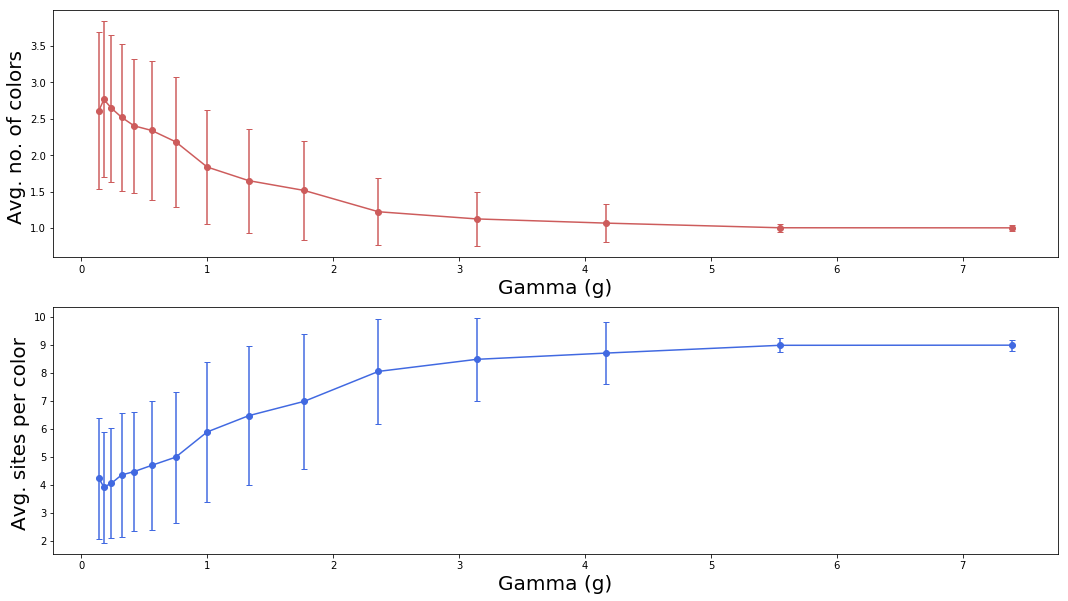

In [8]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0.4, alpha=0.5)

In [173]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 6, gammas, J=0.4, alpha=0.5)

In [174]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 3, gammas, J=0.4, alpha=0.5)

In [175]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 5, gammas, J=0.4, alpha=0.5)

In [176]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 10, gammas, J=0.4, alpha=0.5)

In [177]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0.4, alpha=0.5)

In [ ]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 10, gammas, J=0.4, alpha=0.5)

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.01188174 0.00720664 0.00437105 0.00265118 0.00160802
 0.00097531 0.00059156 0.00091188]
Trying gammas: [0.14 0.18 0.24 0.32 0.42 0.56 0.75 1.   1.33 1.77 2.36 3.14 4.17 5.55
 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.0490313  0.04262577 0.03705706 0.03221586 0.02800713
 0.02434823 0.02116733 0.14085842]
Initial configuration
[[13  6 13  8  5]
 [13  4 14  3 10]
 [ 8 10  4  4 14]
 [14  1 12  8  2]
 [ 5  7 12  5  3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.9702970297029703 avg. sites per col: 7.3125884016973135
201 num. cols: 3.9303482587064678 avg. sites per col: 7.17691305377872
301 num. cols: 4.006

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.386138613861386 avg. sites per col: 8.193658651579447
201 num. cols: 3.199004975124378 avg. sites per col: 9.24988154465766
301 num. cols: 3.179401993355482 avg. sites per col: 9.118414807783592
401 num. cols: 3.1496259351620948 avg. sites per col: 9.157463484146797
501 num. cols: 3.1497005988023954 avg. sites per col: 9.022074897823416
601 num. cols: 3.091514143094842 avg. sites per col: 9.272838919261543
701 num. cols: 3.094151212553495 avg. sites per col: 9.225001698254179
801 num. cols: 3.101123595505618 avg. sites per col: 9.25777302181794
901 num. cols: 3.178690344062153 avg. sites per col: 9.00698958828811
1001 num. cols: 3.144855144855145 avg. sites per col: 9.144902716331268
Final configuration:
[[1 1 1 2 3]
 [1 1 1 2 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [2 1 1 1 1]]
Final averages: 3.144278606965174 9.

101 num. cols: 1.3762376237623761 avg. sites per col: 20.627062706270625
201 num. cols: 1.6517412935323383 avg. sites per col: 18.138474295190733
301 num. cols: 1.6345514950166113 avg. sites per col: 18.313953488372103
401 num. cols: 1.6134663341645885 avg. sites per col: 18.635702410640064
501 num. cols: 1.5848303393213572 avg. sites per col: 18.987025948103806
601 num. cols: 1.6272878535773712 avg. sites per col: 18.462285080421548
701 num. cols: 1.5777460770328102 avg. sites per col: 18.89562529719451
801 num. cols: 1.5905118601747816 avg. sites per col: 18.76300457761135
901 num. cols: 1.5993340732519423 avg. sites per col: 18.59970403255645
1001 num. cols: 1.5764235764235763 avg. sites per col: 18.785381285381312
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [2 1 1 1 1]
 [1 2 2 1 1]
 [1 1 1 1 2]]
Final averages: 1.5781094527363184 18.760364842454422
Final stds: 0.7018939608649625 6.853774311299493
----------------------------------------------------------------------------------

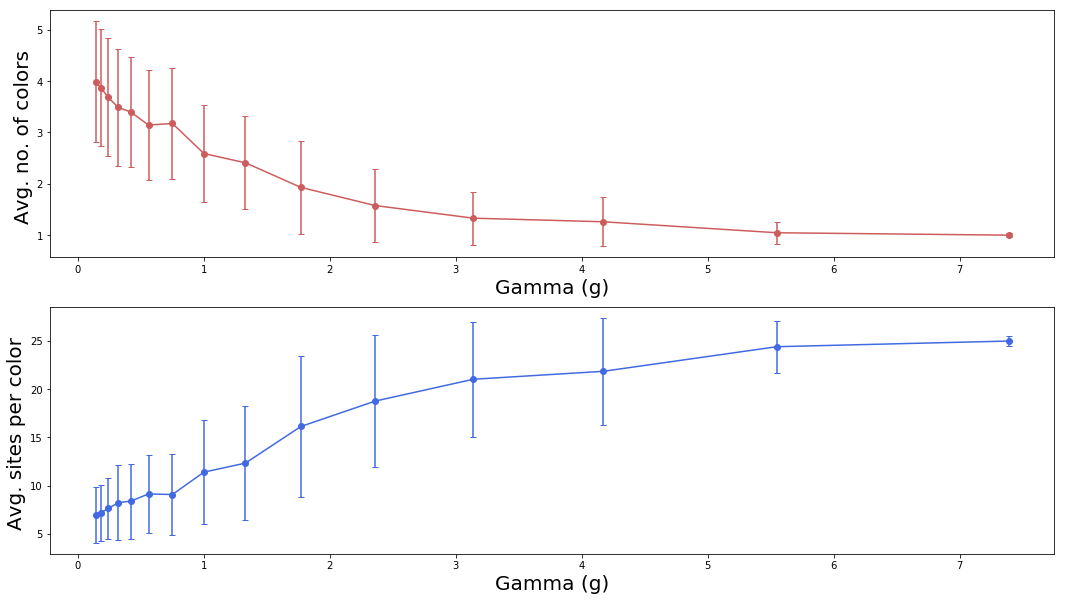

In [9]:
ngamma = 15
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 15, gammas, J=0.4, alpha=0.5)

In [ ]:
ngamma = 10
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (8, 8, gammas, J=0.4, alpha=0.5)

In [158]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (5, 5, alphas, J=0.4, gamma=0.5)

In [ ]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (8, 8, alphas, J=0.4, gamma=0.5)

In [170]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (8, 4, alphas, J=0.4, gamma=0.5)

In [163]:
nJ = 10
Js = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (5, 5, Js, alpha=0.5, gamma=0.5)

In [10]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (8, 8, Js, alpha=0.5, gamma=0.5)

lambda probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.03019738]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.03019738]
Trying Js: [0.14 0.16 0.19 0.22 0.25 0.3  0.35 0.41 0.48 0.56 0.66 0.77 0.9  1.05
 1.23 1.45 1.69 1.98 2.32 2.72]
0  - J: 0.14
edge probabilities: [0.24421626 0.75578374]
Initial configuration
[[7 6 6 7 2 3 6 1]
 [3 8 2 8 4 2 1 7]
 [8 2 4 1 4 5 3 7]
 [1 3 4 2 3 4 5 5]
 [5 7 5 8 6 2 5 6]
 [3 6 6 7 6 6 5 8]
 [4 2 2 6 8 8 2 5]
 [3 2 1 3 4 6 4 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 12.8
101 num. cols: 6.603960396039604 avg. sites per col: 9.916831683168308
201 num. cols: 6.472636815920398 avg. sites per col: 10.104904051172712
301 num. cols: 6.48172757475083 avg. sites per col: 10.084480303749425
401 num. cols: 6.4937655860

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 12.8
101 num. cols: 5.603960396039604 avg. sites per col: 11.835172088637426
201 num. cols: 5.477611940298507 avg. sites per col: 12.21966358682777
301 num. cols: 5.428571428571429 avg. sites per col: 12.286157253599136
401 num. cols: 5.55860349127182 avg. sites per col: 11.971214820092657
501 num. cols: 5.512974051896207 avg. sites per col: 12.060906757912795
601 num. cols: 5.447587354409317 avg. sites per col: 12.202139291656827
701 num. cols: 5.445078459343795 avg. sites per col: 12.206779430745236
801 num. cols: 5.466916354556804 avg. sites per col: 12.174496165507387
901 num. cols: 5.452830188679245 avg. sites per col: 12.194281486179309
1001 num. cols: 5.5054945054945055 avg. sites per col: 12.067094809951838
Final configuration:
[[2 2 1 2 2 1 1 1]
 [2 5 1 1 1 1 1 1]
 [1 1 5 1 1 2 1 1]
 [1 1 1 1 1 1 2 2]
 [5 3 2 3 1 1 3 

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [167]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (8, 5, Js, alpha=0.5, gamma=0.5)

In [168]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (15, 5, Js, alpha=0.5, gamma=0.5)

In [171]:
nJ = 10
Js = np.logspace(-2,1, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (15, 15, Js, alpha=0.5, gamma=0.5)